<a href="https://colab.research.google.com/github/ankit-rathi/Data-Science-with-Python/blob/master/Tradevesting/myStocks_Stockwise_Comprehensive_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import datetime
import pytz
tz_NY = pytz.timezone('Asia/Kolkata')
datetime_NY = datetime.datetime.now(tz_NY)
print("Run date time (IST):", datetime_NY.strftime("%Y-%m-%d %H:%M:%S"))

Run date time (IST): 2023-06-29 11:24:55


In [2]:
# install libraries
!pip install yfinance
!pip install pandas-ta
#!pip install talib-binary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218908 sha256=3abd3ddd1b2bab4c51758cbfd77236e8ba2899eb943d75f86d180af085c3a858
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas-ta


In [3]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

df_ps_features = pd.read_csv('/content/drive/My Drive/data/stocks/myProspectsScrips.csv')

df_pf_analysis = pd.read_csv('/content/drive/My Drive/data/stocks/myStocks-Portfolio-Analysis.csv')

df_ps_buysell = pd.read_csv('/content/drive/My Drive/data/stocks/myProspects-Buy-Sell-Signals.csv')

df_ps_accdis = pd.read_csv('/content/drive/My Drive/data/stocks/myProspects-Acc-Dis-Signals.csv')


Mounted at /content/drive


In [4]:
# import necessary libraries

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')
import pandas_datareader.data as web
import yfinance as yfin
#import talib
yfin.pdr_override()
import pandas_ta as ta

def stock_prec_dev(stock_symbol, date):
    #stock_symbol = 'ULTRACEMCO.NS'
    short_window = 20
    mid_window = 50
    long_window = 200
    moving_avg = 'SMA'

    end_date = date.strftime('%Y-%m-%d')
    start_date = (date + datetime.timedelta(days=-365*3)).strftime('%Y-%m-%d')
    # import the closing price data of the stock for the aforementioned period of time in Pandas dataframe
    #start = datetime.datetime(*map(int, start_date.split('-')))
    #end = datetime.datetime(*map(int, end_date.split('-')))
    stock_df = yfin.Ticker(stock_symbol).history(period='3y')[map(str.title, ['open', 'close', 'low', 'high', 'volume'])]
    stock_df = stock_df[(stock_df.index <= end_date) & (stock_df.index >= start_date)]
    #stock_df = pd.DataFrame(stock_df) # convert Series object to dataframe
    #stock_df.columns = {'Close Price'} # assign new colun name
    stock_df.dropna(axis = 0, inplace = True) # remove any null rows

    # column names for long and short moving average columns
    short_window_col = str(short_window) + '_' + moving_avg
    mid_window_col = str(mid_window) + '_' + moving_avg
    long_window_col = str(long_window) + '_' + moving_avg

    #print(stock_df)

    # Create short exponential moving average column
    stock_df[short_window_col] = round(stock_df['Close'].rolling(window = short_window, min_periods = 1).mean(),0)

    stock_df[mid_window_col] = round(stock_df['Close'].rolling(window = mid_window, min_periods = 1).mean(),0)

    #stock_df['RSI'] = round(talib.RSI(stock_df['Close Price'], timeperiod=14),0)

    # Create a long exponential moving average column
    stock_df[long_window_col] = round(stock_df['Close'].rolling(window = long_window, min_periods = 1).mean(),0)
    stock_df['Stock'] = stock_symbol
    stock_df['Dev%_200'] = round((stock_df['Close'] - stock_df['200_SMA'])*100/stock_df['200_SMA'],2)
    stock_df['Close'] = round(stock_df['Close'],0)
    stock_df.drop(['Open', 'Low', 'High', 'Volume'
                   ], axis=1, inplace=True)

    return stock_df

def plot_stock_buy_sell(stock_symbol):
    date = (datetime.date.today() + datetime.timedelta(days=0))
    df_prec_dev = stock_prec_dev(stock_symbol, date)
    df_prec_dev['Signal'] = 0.0
    df_prec_dev['Signal'] = np.where(((df_prec_dev['Close'] < df_prec_dev['20_SMA']) & (df_prec_dev['20_SMA'] < df_prec_dev['50_SMA']) & (df_prec_dev['50_SMA'] < df_prec_dev['200_SMA'])), 1.0, df_prec_dev['Signal'])

    df_prec_dev['Signal'] = np.where(((df_prec_dev['Close'] > df_prec_dev['20_SMA']) & (df_prec_dev['20_SMA'] > df_prec_dev['50_SMA']) & (df_prec_dev['50_SMA'] > df_prec_dev['200_SMA'])), -1.0, df_prec_dev['Signal'])

    df_prec_dev['Position'] = df_prec_dev['Signal'].diff()

    # plot close price, short-term and long-term moving averages
    plt.figure(figsize = (20,10))
    plt.tick_params(axis = 'both', labelsize = 14)
    df_prec_dev['Close'].plot(color = 'k', lw = 1, label = 'Close')
    #stock_df[short_window_col].plot(color = 'g', lw = 1, label = short_window_col)
    df_prec_dev['20_SMA'].plot(color = 'g', lw = 1, label = '20_SMA')
    df_prec_dev['50_SMA'].plot(color = 'm', lw = 1, label = '50_SMA')
    df_prec_dev['200_SMA'].plot(color = 'b', lw = 1, label = '200_SMA')

    df_pos = df_prec_dev[(df_prec_dev['Position'] >= 1) | (df_prec_dev['Position'] <= -1)]
    df_pos = df_pos[df_pos['Signal'] != 0]
    df_pos['Prev_Signal'] = df_pos['Signal'].shift(1)
    df_pos = df_pos[df_pos['Signal'] != df_pos['Prev_Signal']]
    df_pos.drop('Prev_Signal', axis=1, inplace=True)


    # plot 'buy' signals
    plt.plot(df_pos[df_pos['Position'] >= 1].index,
          df_pos['Close'][df_pos['Position'] >= 1],
          '^', markersize = 15, color = 'g', alpha = 0.7, label = 'buy')

    # plot 'sell' signals
    plt.plot(df_pos[df_pos['Position'] <= -1].index,
          df_pos['Close'][df_pos['Position'] <= -1],
          'v', markersize = 15, color = 'r', alpha = 0.7, label = 'sell')

    plt.ylabel('Price in ₹', fontsize = 16 )
    plt.xlabel('Date', fontsize = 16 )
    plt.title(stock_symbol + '  : Buy/Sell Signal', fontsize = 20)
    plt.legend()
    plt.grid()
    plt.show()

    display_table = True

    if display_table == True:
      print(stock_symbol)
      df_pos['Position'] = df_pos['Position'].apply(lambda x: 'Buy' if x >= 1 else 'Sell')
      print(tabulate(df_pos, headers = 'keys', tablefmt = 'psql'))

In [5]:
stock_id =  'RELIANCE.NS'
df_ps_features[df_ps_features['Stock'] == stock_id]


,Symbol,AvgCost,Target,Shares,MedianPE,Nifty100,Criteria,Strategy,InPortfolio,LatestQtr,StarStock,BizSimple,BizType,BizOutlook,BizDurability,Conviction,Category,Stock
140,RELIANCE,2467.15,NaN,31.0,29.1,1.0,V40,ATH,1,1.0,1.0,0.0,G,1.0,0.0,H,REFINERIES,RELIANCE.NS


In [6]:
print('Stock:', df_ps_features[df_ps_features['Stock'] == stock_id]['Symbol'].values[0])
print('Avg Cost:', df_ps_features[df_ps_features['Stock'] == stock_id]['AvgCost'].values[0])
print('Shares:', df_ps_features[df_ps_features['Stock'] == stock_id]['Shares'].values[0])
print('MedianPE:', df_ps_features[df_ps_features['Stock'] == stock_id]['MedianPE'].values[0])
print('Category:', df_ps_features[df_ps_features['Stock'] == stock_id]['Category'].values[0])
print('Current P/L%:', df_pf_analysis[df_pf_analysis['Stock'] == stock_id]['Current P/L%'].values[0])
print('Estimated P/L%:', df_pf_analysis[df_pf_analysis['Stock'] == stock_id]['Estimated P/L%'].values[0])
print('Weightage%:', df_pf_analysis[df_pf_analysis['Stock'] == stock_id]['Weightage%'].values[0])
print('Dev%_200:', df_ps_accdis[df_ps_accdis['Stock'] == stock_id]['Dev%_200'].values[0])

Stock: RELIANCE
Avg Cost: 2467.15
Shares: 31.0
MedianPE: 29.1
Category: REFINERIES
Current P/L%: 2.56
Estimated P/L%: 13.94
Weightage%: 2.6
Dev%_200: 2.78


In [7]:
df_pf_analysis[df_pf_analysis['Stock'] == stock_id]

,Close,Stock,Max,Prev_Close,Avg_Cost,Shares,Criteria,Strategy,Investment,Current,Previous,Estimated,Today P/L%,Current P/L%,Estimated P/L%,Juice Left%,Weightage%,Risk Ind
35,2530.35,RELIANCE.NS,2811.0,2496.45,2467.15,31.0,V40,ATH,76481.65,78440.85,77389.95,87141.0,1.36,2.56,13.94,11.38,2.6,7.0


In [8]:
df_ps_buysell[df_ps_buysell['Stock'] == stock_id]

,Date,Close,20_SMA,50_SMA,200_SMA,Stock,Dev%_200,Signal,Position,Criteria
73,2023-06-28 00:00:00+05:30,2530.0,2514.0,2469.0,2462.0,RELIANCE.NS,2.78,-1.0,Sell,V40


In [9]:
df_ps_accdis[df_ps_accdis['Stock'] == stock_id]

,Date,Close,Stock,Dev%_200,StarStock,Criteria,Acc,Dis
62,2023-06-28 00:00:00+05:30,2530.0,RELIANCE.NS,2.78,1.0,V40,-5.0,11.0


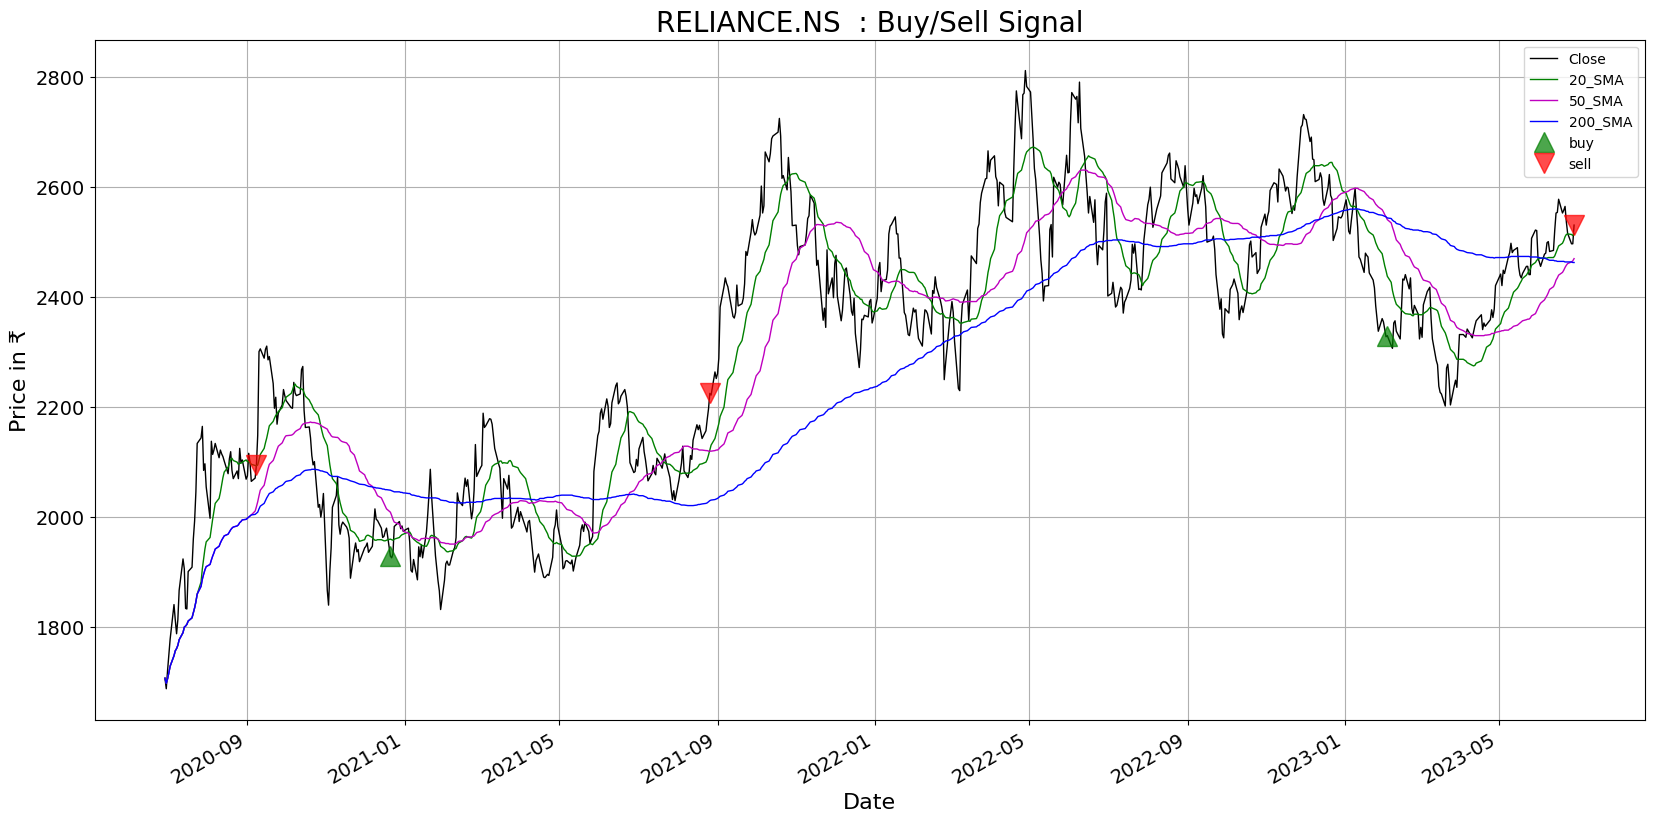

RELIANCE.NS
+---------------------------+---------+----------+----------+-----------+-------------+------------+----------+------------+
| Date                      |   Close |   20_SMA |   50_SMA |   200_SMA | Stock       |   Dev%_200 |   Signal | Position   |
|---------------------------+---------+----------+----------+-----------+-------------+------------+----------+------------|
| 2020-09-08 00:00:00+05:30 |    2094 |     2092 |     2018 |      2006 | RELIANCE.NS |       4.39 |       -1 | Sell       |
| 2020-12-21 00:00:00+05:30 |    1928 |     1959 |     2008 |      2048 | RELIANCE.NS |      -5.88 |        1 | Buy        |
| 2021-08-26 00:00:00+05:30 |    2224 |     2121 |     2119 |      2029 | RELIANCE.NS |       9.6  |       -1 | Sell       |
| 2023-02-03 00:00:00+05:30 |    2329 |     2437 |     2540 |      2543 | RELIANCE.NS |      -8.42 |        1 | Buy        |
| 2023-06-28 00:00:00+05:30 |    2530 |     2514 |     2469 |      2462 | RELIANCE.NS |       2.78 |       -1 | S

In [10]:
plot_stock_buy_sell(stock_id)